In [1]:
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

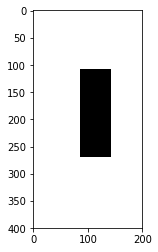

[[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 ...

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]]


In [2]:
map_data = mpimg.imread('map3.png')
plt.imshow(map_data)
plt.show()

x_start = np.array([350, 100])
x_goal = np.array([50, 100])

In [3]:
def add_margin(map_data,margin=5,obs_color=[0., 0., 0.]):
    H, W, _ = map_data.shape
    margin_map_data = np.zeros_like(map_data)
    for i in range(H):
        for j in range(W):
            if (map_data[i][j]==obs_color).all():
                for k in range(-margin,margin):
                    for l in range(-margin,margin):
                        if not (margin_map_data[np.clip(i+k,0,H-1)][np.clip(j+l,0,W-1)]==obs_color).all():
                            margin_map_data[np.clip(i+k,0,H-1)][np.clip(j+l,0,W-1)] = obs_color
            else:
                margin_map_data[i][j] = map_data[i][j]
    return margin_map_data

def dist(x1,x2):
    return np.sqrt(np.sum((x1-x2)**2))

def collision_free(x1,x2,map_data,check_length=0.5,obs_color=[0., 0., 0.]):
    moving_direction = x1 - x2
    moving_length = np.sqrt(np.sum(moving_direction**2))
    if moving_length > 0.0:
        moving_direction = moving_direction/moving_length
    i = 0
    while moving_length > check_length*i:
        xi = x2 + check_length*i*moving_direction
        if iscollision(xi,map_data,obs_color=obs_color):
            return False    
        i+=1
    return True
    
def iscollision(p,map_data,obs_color=[0., 0., 0.]):    #check if point collides with the obstacle
    H, W, _ = map_data.shape
    if int(p[0]) > H-1 or int(p[0]) < 0:
        return True
    elif int(p[1]) > W-1 or int(p[1]) < 0:
        return True
    else:
        if (map_data[int(p[0]),int(p[1])]==obs_color).all():
            return True
        else:
            return False

def sample_free(map_data,obs_color=[0., 0., 0.]):
    H, W, _ = map_data.shape
    while True:
        p = np.array([int(np.random.random()*H), int(np.random.random()*W)])
        if not iscollision(p,map_data,obs_color):
            return p
        
def sample_goal(x_goal):
    return x_goal

def nearest(nodes,x):
    nearest_node=None
    nearest_dist=np.inf
    for search_node in nodes:
        if nearest_dist > dist(x, search_node.point):
            nearest_dist = dist(x, search_node.point)
            nearest_node = search_node
    return nearest_node

def steer(nearest_node,x,pixel_length=20):
    moving_direction = x - nearest_node.point
    moving_length = np.sqrt(np.sum(moving_direction**2))
    if moving_length > pixel_length:
        moving_direction = moving_direction/moving_length
    else:
        moving_direction = moving_direction/pixel_length        
    return nearest_node.point + pixel_length*moving_direction

def near_set(nodes,x,k=10):
    dist_list=[]
    for search_node in nodes:
        dist_list.append(dist(x,search_node.point))
    sorted_indices=np.argsort(dist_list)
    selected_indices=sorted_indices[:k]
    near_set=[]
    for idx in selected_indices:
        near_set.append(nodes[idx])
    return near_set
    
class Node(object):
    def __init__(self, point, parent, cost):
        super(Node, self).__init__()
        self.point = point
        self.parent = parent
        self.cost = cost
        
def rrt_planner(x_start, x_goal, map_data, margin=5, number_of_nodes=100, epsilon=0.1, obs_color=[0., 0., 0.]):
    if len(map_data.shape) > 3:
        map_data = map_data[:,:,:3]
    
    margin_map_data = add_margin(map_data,margin=margin,obs_color=obs_color)
    nodes = [Node(x_start,None,0)]
    goal_node = None
    for i in range(number_of_nodes):
        if np.random.uniform() > epsilon:
            x_rand = sample_free(margin_map_data)
        else:
            x_rand = sample_goal(x_goal)
        nearest_node = nearest(nodes,x_rand)
        x_new = steer(nearest_node,x_rand)
        if not iscollision(x_new,margin_map_data,obs_color=obs_color):
            near_node_set = near_set(nodes,x_new)
            x_min = x_new
            c_min = nearest_node.cost + dist(nearest_node.point,x_new)
            node_min = nearest_node
            for near_node in near_node_set:
                if collision_free(near_node.point,x_new,margin_map_data,obs_color=obs_color) and near_node.cost + dist(near_node.point,x_new) < c_min:
                    x_min = x_new
                    c_min = near_node.cost + dist(near_node.point,x_new)
                    node_min = near_node
            node_new = Node(x_new,node_min,c_min)
            nodes.append(node_new)
            for near_node in near_node_set:
                if collision_free(node_new.point,near_node.point,margin_map_data,obs_color=obs_color) and node_new.cost + dist(node_new.point,near_node.point) < near_node.cost:
                    near_node.parent = node_new
                    near_node.cost = node_new.cost + dist(node_new.point,near_node.point)
            if dist(x_new,x_goal) < 0.5: 
                if goal_node is None:
                    goal_node = node_new
                    print("The solution is found : %f"%goal_node.cost)
    return goal_node, nodes, margin_map_data

The solution is found : 313.759567


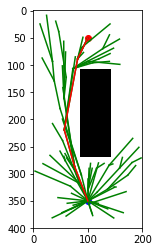

In [4]:
goal_node, nodes, margin_map_data = rrt_planner(x_start, x_goal, map_data, obs_color=[0., 0., 0.])

plt.imshow(map_data)
plt.plot(x_goal[1],x_goal[0],'ro')
plt.plot(x_start[1],x_start[0],'bo')
for node in nodes:
    if node.parent is not None:
        plt.plot([node.point[1],node.parent.point[1]],[node.point[0],node.parent.point[0]],'g-')
while goal_node is not None:
    if goal_node.parent is not None:
        plt.plot([goal_node.point[1],goal_node.parent.point[1]],[goal_node.point[0],goal_node.parent.point[0]],'r-')
    goal_node = goal_node.parent
plt.show()